<a href="https://colab.research.google.com/github/EduMoura321/Non-linear-systems/blob/main/flutter_nao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autovalores: [ 1.94110684e+02 +0.j         -1.94802871e+02 +0.j
 -1.76280486e-01+77.51090063j -1.76280486e-01-77.51090063j
  4.39249821e-02 +0.j         -2.00000001e+00 +0.j
 -4.99999809e+00 +0.j         -1.00000000e+00 +0.j
 -5.00000000e+00 +0.j         -2.00000000e+00 +0.j        ]
Parte real: [ 1.94110684e+02 -1.94802871e+02 -1.76280486e-01 -1.76280486e-01
  4.39249821e-02 -2.00000001e+00 -4.99999809e+00 -1.00000000e+00
 -5.00000000e+00 -2.00000000e+00]


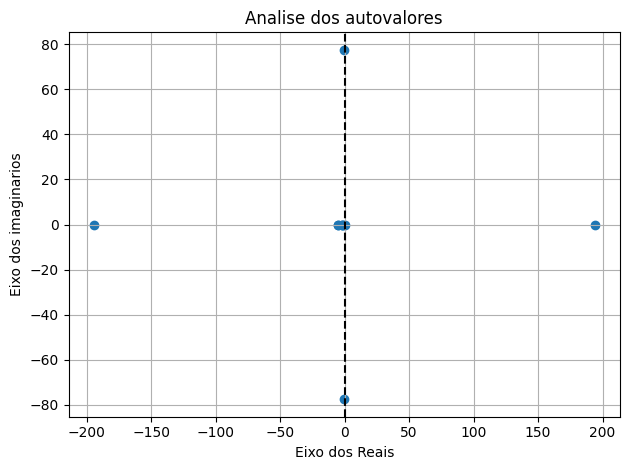

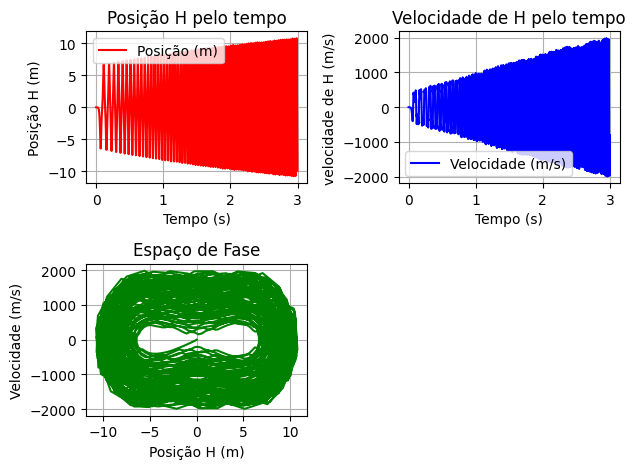

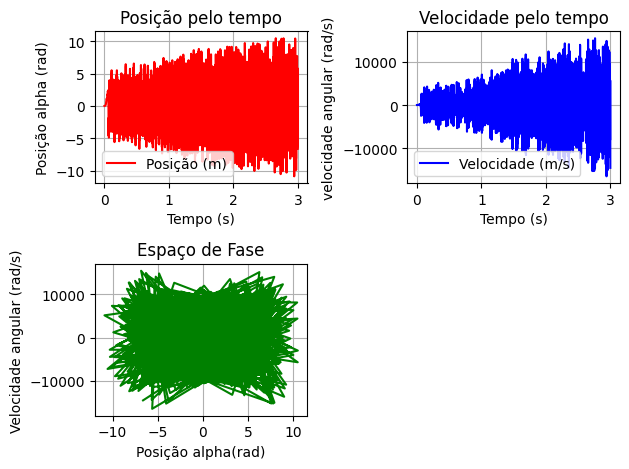

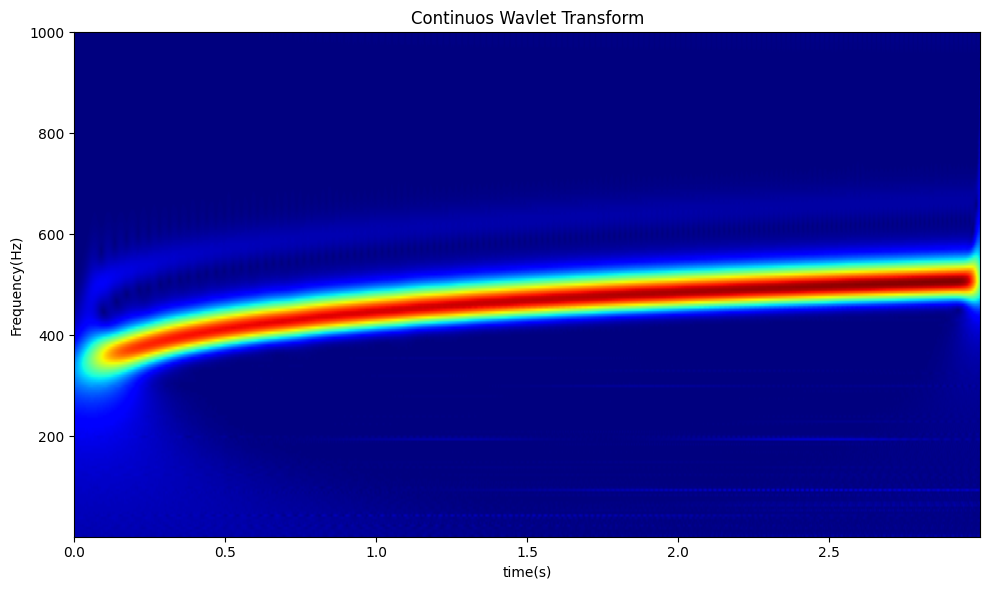

In [ ]:
'''
=====================================================================
Nome do programa: Simulação de aerofolio sob força de Padé
Data: 19/09/2025
Linguagem: Phyton
Depêndencias: Mathplotlib, Numpy e scipy
--------------------------------------------------------------------
Nome: Eduardo Moura Ventorim
Instituto de Física
UFMS - Campo Grande
Descrição: Programa que realiza a partir de metódos númericos a
solução do dominio temporal da EDO que descreve um aerofolio em regime
aerodinamico simples, e analisa seu comportamente passivo de efeito flutter
===================================================================
'''
#====================================================================
#Bibliotecas utilizadas:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy import signal
from scipy.special import hankel2
import pywt
#=====================================================================
#parametros físicos do sistema
C_aero = 0.1 #amortecimento aerodinamico[M/s]
L = 0.28 #envergadura do aviao [M]
b = 0.05 #metade da corda [M]
c = 0.1 #tamanho total da corda[M]
xab = 0.34*b #distancia do C.g e meio da corda [M]
m = 1.35 #massa de mergulho [Kg]
Ig = 7.741e-4 #momento de inercia do mergulho [Kg * m^2]
kh = 906.81 #rigidez mola transversal [N/M]
ka = 11.5 #rigidez mola torcional [N/rad]
U = 100 #velocidade do escoamento[M/s]
p = 1.225 #densidade do ar [Kg/m^3]
e = 0.00
#======================================================================
#matriz de força dinamica do modelo
def theodorsen(k_in):
    k = np.asarray(k_in, dtype=float)
    C = np.empty_like(k, dtype=complex)
    small = np.isclose(k, 0.0, atol=1e-12)
    nonzero = ~small
    if np.any(nonzero):
        H0 = hankel2(0, k[nonzero])
        H1 = hankel2(1, k[nonzero])
        C[nonzero] = H1/ (H1 + 1j * H0)
    if np.any(small):
        C[small] = 1.0 + 0j
    return C.item() if np.isscalar(k_in) else C
def Mat_theordsem(k):
    k = np.asarray(k, dtype=complex)
    #func theor
    k_for_c = np.abs(k.real) if np.iscomplexobj(k) else np.abs(k)
    Ck = theodorsen(k_for_c)
    Mat_transf1 = np.array([
    [0,      -2*np.pi       ],
    [0,       4*np.pi*b*e  ]
    ], dtype=complex)

    Mat_transf2 = np.array([
    [-2*np.pi*(k/b), 0       ],
    [ 4*np.pi*k*e  ,       0 ]], dtype=complex)

    q = 0.5 * p *C_aero*L*U**2
    Mtt =  q*(Ck* Mat_transf1 + (Ck* Mat_transf2))
    return Mtt
#=====================================================================
#aproximação racional de roger ajustada com tikhonov
def roger_fit(Mats,S_usd, gammas, ridge=1e-6):
    s_arr = np.array(S_usd, dtype=complex)
    m = len(s_arr)
    n = Mats.shape[1]
    r = len(gammas)
    nterms = 3 + r  # A0, A1, r*A_i

    Phi = np.zeros((m, nterms), dtype=complex)
    for idx, s in enumerate(s_arr):
       Phi[idx, :] = [1,0, s] + [1.0/ (s+g) for g in gammas]
    A0 = np.zeros((n, n), dtype=float)
    A1 = np.zeros((n, n), dtype=float)
    Ais = [np.zeros((n, n), dtype=float) for _ in range(r)]
    A_real = np.vstack([Phi.real, Phi.imag])
    for i in range(n):
        for j in range(n):
            y_complex = Mats[:,i,j]
            b_real = np.hstack([y_complex.real, y_complex.imag])  # (2m,)
            theta, *_ = np.linalg.lstsq(A_real, b_real, rcond=None)  # theta shape (nterms,)
            A0[i, j] = theta[0]
            A1[i, j] = theta[1]
            for k_g in range(r):
                Ais[k_g][i, j] = theta[2 + k_g]

    return A0, A1, Ais
#=====================================================================
#espaço de estado novo:
def buildar_novo_esp(M,C_estru,K,A0,A1,Ais, Gammas):
    n = M.shape[0]
    r = len(Ais)
    Ntotal = 2*n + r*n
    A = np.zeros((Ntotal, Ntotal))
    Minv = np.linalg.inv(M)
    A[0:n, n:2 * n] = np.eye(n)

    #dinamica estrutrual
    A[n:2 * n, 0:n] = -Minv @ (K - A0)
    A[n:2 * n, n:2 * n] = -Minv @ (C_estru - A1)

    #dinamica dos lags
    for i, (Ai,gamma) in enumerate(zip(Ais, Gammas)):
        row =  2*n + i*n
        A[row:row + n, n:2 * n] = np.eye(n)
        A[row:row + n, row:row + n] = -gamma * np.eye(n)
        # Acoplamento do lag na equação estrutural
        A[n:2 * n, row:row + n] += -Minv @ Ai
    return A
#=====================================================================
if __name__ == "__main__":
    M = np.array([[m ,xab*m],
                  [xab*m , Ig+m*(xab)**2]], dtype=float) #matriz de massa
    K = np.array([[kh, 0],[0,ka]],  dtype=float) #matriz de rigidez
    C_estru = np.zeros_like(K) #Matriz de amortecimento
    #pontos de amostragem de frequência
    omegas = np.linspace(0.5,8, 12)
    S_usd = 1j*(omegas*b/U)
    #constantes de decaimento dos lags
    gammas = [1.0,2.0,5.0]
    #ja deixa calculado mat theordsem para optimizar cod
    Mats = np.zeros((len(S_usd), 2, 2),dtype=complex)
    for i, s in enumerate(S_usd):
        Mats[i, :, :] = Mat_theordsem(s)
    #ajuste de roger
    A0,A1,Ais = roger_fit(Mats, S_usd, gammas)
    #monta espaço de estado
    A_aum = buildar_novo_esp(M,C_estru,K, A0,A1,Ais, gammas)
#=====================================================================
#achar autovalores
eigval = np.linalg.eigvals(A_aum)
print('Autovalores:', eigval)
print('Parte real:', eigval.real)

#simular no tempo
# condições iniciais
n = M.shape[0]  # número de GDLs
r = len(Ais)  # número de lags
Ntotal = 2 * n + r * n  # tamanho total do sistema aumentado

X0 = np.zeros(Ntotal)  # todos estados inicialmente zero
X0[0] = 0.01  # pequeno deslocamento inicial no q1
X0[1] = 0.01  # pequeno deslocamento inicial no q2


# não-linearização
Minv = np.linalg.inv(M)
alpha = np.array([1000.0, 50.0])

def f_nl(q):
  return alpha * (q ** 3)

def sys_aug(t, X):
  dX = A_aum @ X
  q = X[0:n]
  fnl = f_nl(q)
  dX[n:2 * n] += -Minv @ fnl
  return dX
#-----------------------------------------------------
# simulação temporal
t_span = (0, 3)
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)

sol = solve_ivp(sys_aug, t_span, X0, t_eval=t_eval,method='LSODA', atol=1e-6, rtol=1e-4)
#=====================================================================
# Pega os estados
q1 = sol.y[0, :] #Altura
q2 = sol.y[1, :] #Angulo de ataque
dq1 = sol.y[n, :] #velocidade altura
dq2 = sol.y[n + 1, :] #velocidade angular
#=====================================================================
#plot dos grafícos
plt.figure()
plt.scatter(eigval.real, eigval.imag,)
plt.axvline(0, color='k',linestyle='--')
plt.title('Analise dos autovalores')
plt.grid(True)
plt.xlabel('Eixo dos Reais')
plt.ylabel('Eixo dos imaginarios')
plt.tight_layout()
plt.show()
#---------------------------------------------------------------------------
#gráficos de altura

#Gráfico de posíção
plt.figure()
plt.subplot(2,2,1)
plt.plot(sol.t, q1, label='Posição (m)', color='red')
plt.legend()
plt.title('Posição H pelo tempo')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição H (m)')

#gráfico de velocidade
plt.subplot(2,2,2)
plt.plot(sol.t, dq1, label='Velocidade (m/s)', color='blue')
plt.title('Velocidade de H pelo tempo')
plt.legend()
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('velocidade de H (m/s)')

#gráfico de espaço de fase
plt.subplot(2,2,3)
plt.plot(q1, dq1, color='green')
plt.title('Espaço de Fase')
plt.grid(True)
plt.ylabel('Velocidade (m/s)')
plt.xlabel('Posição H (m)')

plt.tight_layout()
plt.show()
#------------------------------------------------------------------
#gráficos rotacionais
# Gráfico de posíção
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(sol.t, q2, label='Posição (m)', color='red')
plt.legend()
plt.title('Posição pelo tempo')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição alpha (rad)')

# gráfico de velocidade
plt.subplot(2, 2, 2)
plt.plot(sol.t, dq2, label='Velocidade (m/s)', color='blue')
plt.title('Velocidade pelo tempo')
plt.legend()
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('velocidade angular (rad/s)')

# gráfico de espaço de fase
plt.subplot(2, 2, 3)
plt.plot(q2, dq2, color='green')
plt.title('Espaço de Fase')
plt.grid(True)
plt.ylabel('Velocidade angular (rad/s)')
plt.xlabel('Posição alpha(rad)')

plt.tight_layout()
plt.show()
#======================================================================
#Aplicacao da wavelet
time = t_eval
wavelet = "cmor1.5-1.0"
widths = np.geomspace(1, 1024, num=200)
sampling_period = np.diff(time).mean()
cwtmat, freqs = pywt.cwt(q1, widths, wavelet, sampling_period=sampling_period)
cwtmat = np.abs(cwtmat[:-1, :-1])
#plot da wavelet
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(np.abs(cwtmat), extent=[time[0], time[-1], freqs[-1], freqs[0]], aspect='auto', cmap='jet')
ax.set_xlabel('time(s)')
ax.set_ylabel("Frequency(Hz)")
ax.set_title('Continuos Wavlet Transform')
plt.tight_layout()
plt.show()

In [ ]:
#Bacia de atracao
#1 tempos:
t_total = 20
dt = 0.01
t_eval = np.arange(0,t_total, dt)
t_transiente2 = 10
#--------------------------------------------------
#2 grid de condições inicias
x_rng = np.linspace(-2,2, 60)
dx_rng = np.linspace(-2,2,60)
X, V = np.meshgrid(x_rng,dx_rng)
basins = np.zeros(X.shape)
#--------------------------------------------------
#simulações
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        CI_full = np.zeros(Ntotal)
        CI_full[0] = X[i,j]
        CI_full[n] = V[i,j]

        solb = solve_ivp(sys_aug, [0, t_total], CI_full, t_eval=t_eval,method='LSODA', atol=1e-6, rtol=1e-4)
        #filtragem de dados pós transiente
        t_val2 = solb.t
        x_val2 = solb.y[0]
        ind = np.where( t_val2 > t_transiente2)
        x_valbassin = x_val2[ind]

        #classifica para plotar bacia

        final_x = x_valbassin[-1]
        if final_x > 1.0:
            basins[i,j] = 1
        elif final_x < -1.0:
            basins[i,j] = -1
        else:
            basins[i,j] = 0
#------------------------------------------------------
#Plot da bacia
plt.figure(figsize=(8,6))
plt.contourf(X,V, basins, levels=[-1,0,1], colors=['purple','orange','green'], alpha=0.75)
plt.xlabel('Condição inicial H')
plt.ylabel('Condilçao inicial Dh')
plt.title('Bacia de Aerofolio Simples')
plt.colorbar(label='Tipo de atrator')
plt.show()
#========================================================================================================

/tmp/ipython-input-2725680639.py:166: RuntimeWarning: overflow encountered in matmul
  dX[n:2 * n] += -Minv @ fnl
/tmp/ipython-input-2725680639.py:163: RuntimeWarning: invalid value encountered in matmul
  dX = A_aum @ X
/tmp/ipython-input-2725680639.py:166: RuntimeWarning: invalid value encountered in add
  dX[n:2 * n] += -Minv @ fnl
/usr/local/lib/python3.12/dist-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


KeyboardInterrupt: 